In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import talib


def calculate_sortino_ratio(
    returns: pd.Series, risk_free_rate: float = 0.0, annualization_factor: int = 365
):
    """
    Calculate the annualized Sortino Ratio from a pandas Series of returns.

    Parameters:
    - returns: pd.Series of periodic returns (e.g. daily)
    - risk_free_rate: optional, in same period units as returns (e.g. 0.0 for daily, 0.01/252 for 1% annual)
    - annualization_factor: 252 for daily, 12 for monthly, etc.

    Returns:
    - Annualized Sortino Ratio (float)
    """
    # Excess returns
    excess_returns = returns - risk_free_rate

    # Downside deviation (only negative excess returns)
    downside_returns = excess_returns[excess_returns < 0]
    downside_deviation = np.std(downside_returns, ddof=0)

    # Mean excess return
    mean_excess_return = excess_returns.mean()

    # Raw Sortino Ratio
    if downside_deviation == 0:
        return np.inf if mean_excess_return > 0 else -np.inf

    sortino = mean_excess_return / downside_deviation

    # Annualize
    return sortino * np.sqrt(annualization_factor)

In [7]:
df = pd.read_csv("../Data/factor/Binance_BTCUSDT_perpetual_1H_takerbuysellvolume_facto.csv")
sr_multiplier = 24
df = df.dropna()

In [8]:
def backtesting(
    df,
    rolling_window,
    threshold,
    fees,
    sr_multiplier,
    entry_exit_logic,
    model,
    column_name,
):
    # model calculation
    # zscore
    if model == "zscore":
        df["mean"] = df[column_name].rolling(window=rolling_window).mean()
        df["std"] = df[column_name].rolling(window=rolling_window).std()
        df["model_data"] = (df[column_name] - df["mean"]) / df["std"]
    # min-max-scaling (-1 to 1)
    elif model == "min_max_scaling":
        # write the formula
        # x_scaled = 2 * (x - x_min) / (x_max - x_min) - 1
        df["rolling_min"] = df[column_name].rolling(rolling_window).min()
        df["rolling_max"] = df[column_name].rolling(rolling_window).max()
        df["model_data"] = (
            2
            * (df[column_name] - df["rolling_min"])
            / (df["rolling_max"] - df["rolling_min"])
            - 1.0
        )
    elif model == "rsi":
        df["model_data"] = talib.RSI(df[column_name].values, rolling_window)
    model_data = df["model_data"].values

    if model == "rsi":
        upper_threshold = 100 - threshold
        lower_thresold = threshold
    else:
        upper_threshold = threshold
        lower_thresold = -threshold
    # assign pos array with initial pos = 0
    pos = [0]
    long_trades = 0
    short_trades = 0
    # trend
    if entry_exit_logic == "trend":
        for i in range(1, len(model_data)):
            # current model_data more than threshold , pos = 1
            if model_data[i] >= upper_threshold:
                pos.append(1)
                if pos[-2] != pos[-1]:
                    long_trades += 1
            # current model_data less than negative theshold , pos = -1
            elif model_data[i] <= lower_thresold:
                pos.append(-1)
                if pos[-2] != pos[-1]:
                    short_trades += 1
            # current model_data within theshold and negative threshold , pos = previous pos
            else:
                pos.append(pos[-1])
    elif entry_exit_logic == "trend_close_at_zero":
        for i in range(1, len(model_data)):
            # current model_data more than threshold , pos = 1
            if model_data[i] >= upper_threshold:
                pos.append(1)
                if pos[-2] != pos[-1]:
                    long_trades += 1
            # current model_data less than negative theshold , pos = -1
            elif model_data[i] <= lower_thresold:
                pos.append(-1)
                if pos[-2] != pos[-1]:
                    short_trades += 1
            elif (pos[-1] == 1 and model_data[i] <= 0.0) or (
                pos[-1] == -1 and model_data[i] >= 0.0
            ):
                pos.append(0)
            # current model_data within theshold and negative threshold , pos = previous pos
            else:
                pos.append(pos[-1])
    elif entry_exit_logic == "mr":
        for i in range(1, len(model_data)):
            # current model_data more than threshold , pos = -1
            if model_data[i] >= upper_threshold:
                pos.append(-1)
                if pos[-2] != pos[-1]:
                    short_trades += 1
            # current model_data less than negative theshold , pos = 1
            elif model_data[i] <= lower_thresold:
                pos.append(1)
                if pos[-2] != pos[-1]:
                    long_trades += 1
            # current model_data within theshold and negative threshold , pos = previous pos
            else:
                pos.append(pos[-1])
    elif entry_exit_logic == "mr_close_at_zero":
        for i in range(1, len(model_data)):
            # current model_data more than threshold , pos = -1
            if model_data[i] >= upper_threshold:
                pos.append(-1)
                if pos[-2] != pos[-1]:
                    short_trades += 1
            # current model_data less than negative theshold , pos = 1
            elif model_data[i] <= lower_thresold:
                pos.append(1)
                if pos[-2] != pos[-1]:
                    long_trades += 1
            # if current pos == 1 , model_data >= 0.0 , close long
            # if current pos == -1 , model_data <= 0.0 , close short
            elif (model_data[i] >= 0.0 and pos[-1] == 1) or (
                model_data[i] <= 0.0 and pos[-1] == -1
            ):
                pos.append(0)
            # current model_data within theshold and negative threshold , pos = previous pos
            else:
                pos.append(pos[-1])

    df["pos"] = pos
    # calculate return
    df["return"] = df["close"].pct_change()
    # get the previous pos to a new column
    df["pos_shift"] = df["pos"].shift(1)
    # calculate trades
    df["trades"] = abs(df["pos"] - df["pos_shift"])
    # calculate pnl
    fees = 0.06
    df["pnl"] = df["pos_shift"] * df["return"] - df["trades"] * fees / 100
    df["cumu"] = df["pnl"].cumsum()
    df["dd"] = df["cumu"] - df["pnl"].cummax()
    sr = df["pnl"].mean() / df["pnl"].std() * np.sqrt(365 * sr_multiplier)
    cr = df["pnl"].mean() / abs(df["dd"].min())
    sortino_ratio = calculate_sortino_ratio(df["pnl"])
    number_of_trades = df["trades"].sum()
    ar = df["pnl"].mean() * 365
    report = {
        "Model": model,
        "Entry Exit Logic": entry_exit_logic,
        "Rolling Window": rolling_window,
        "Threshold": threshold,
        "SR": sr,
        "CR": cr,
        "AR": ar,
        "MDD": df["dd"].min(),
        "Sortino Ratio": sortino_ratio,
        "Number of Trades": number_of_trades,
    }
    # return the report
    return report, df

C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:127: RuntimeWarning: invalid value encountered in scalar divide
  sr = df["pnl"].mean() / df["pnl"].std() * np.sqrt(365 * sr_multiplier)
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:128: RuntimeWarning: invalid value encountered in scalar divide
  cr = df["pnl"].mean() / abs(df["dd"].min())
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:127: RuntimeWarning: invalid value encountered in scalar divide
  sr = df["pnl"].mean() / df["pnl"].std() * np.sqrt(365 * sr_multiplier)
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:128: RuntimeWarning: invalid value encountered in scalar divide
  cr = df["pnl"].mean() / abs(df["dd"].min())
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:127: RuntimeWarning: invalid value encountered in scalar divide
  sr = df["pnl"].mean() / df["pnl"].std() * np.sqrt(365 * sr_multiplier)
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\27178

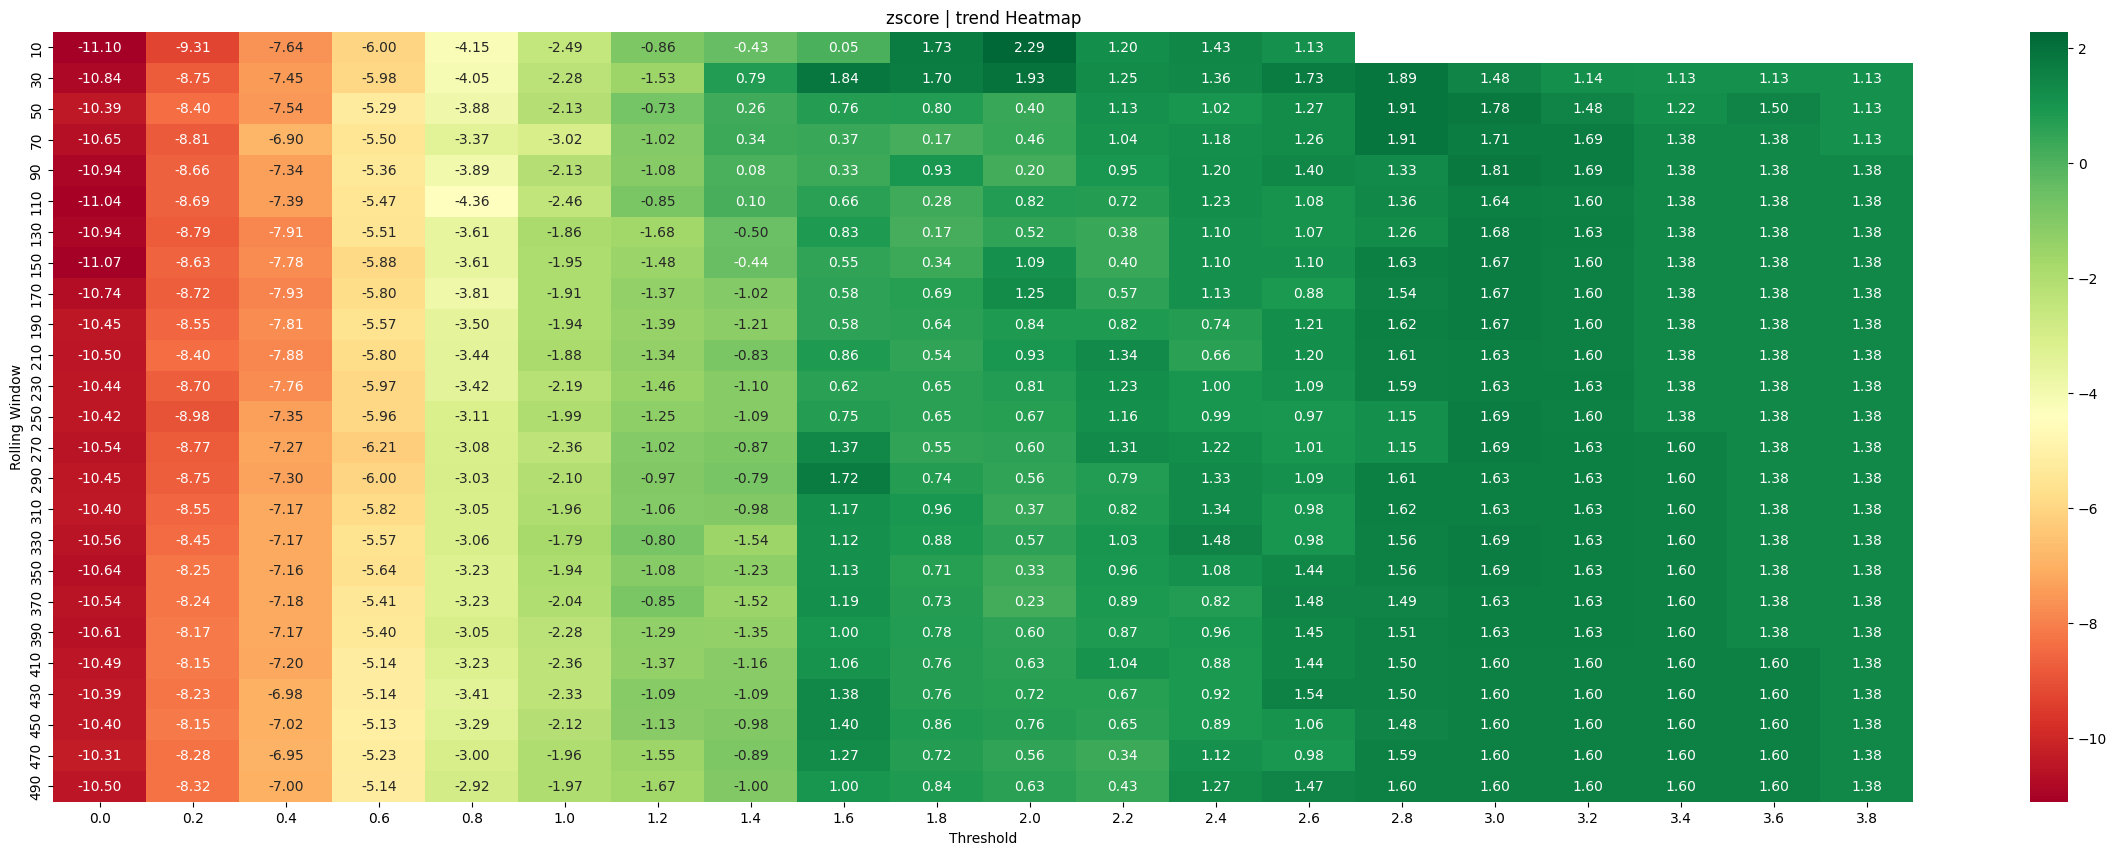

C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:127: RuntimeWarning: invalid value encountered in scalar divide
  sr = df["pnl"].mean() / df["pnl"].std() * np.sqrt(365 * sr_multiplier)
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:128: RuntimeWarning: invalid value encountered in scalar divide
  cr = df["pnl"].mean() / abs(df["dd"].min())
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:127: RuntimeWarning: invalid value encountered in scalar divide
  sr = df["pnl"].mean() / df["pnl"].std() * np.sqrt(365 * sr_multiplier)
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:128: RuntimeWarning: invalid value encountered in scalar divide
  cr = df["pnl"].mean() / abs(df["dd"].min())
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:127: RuntimeWarning: invalid value encountered in scalar divide
  sr = df["pnl"].mean() / df["pnl"].std() * np.sqrt(365 * sr_multiplier)
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\27178

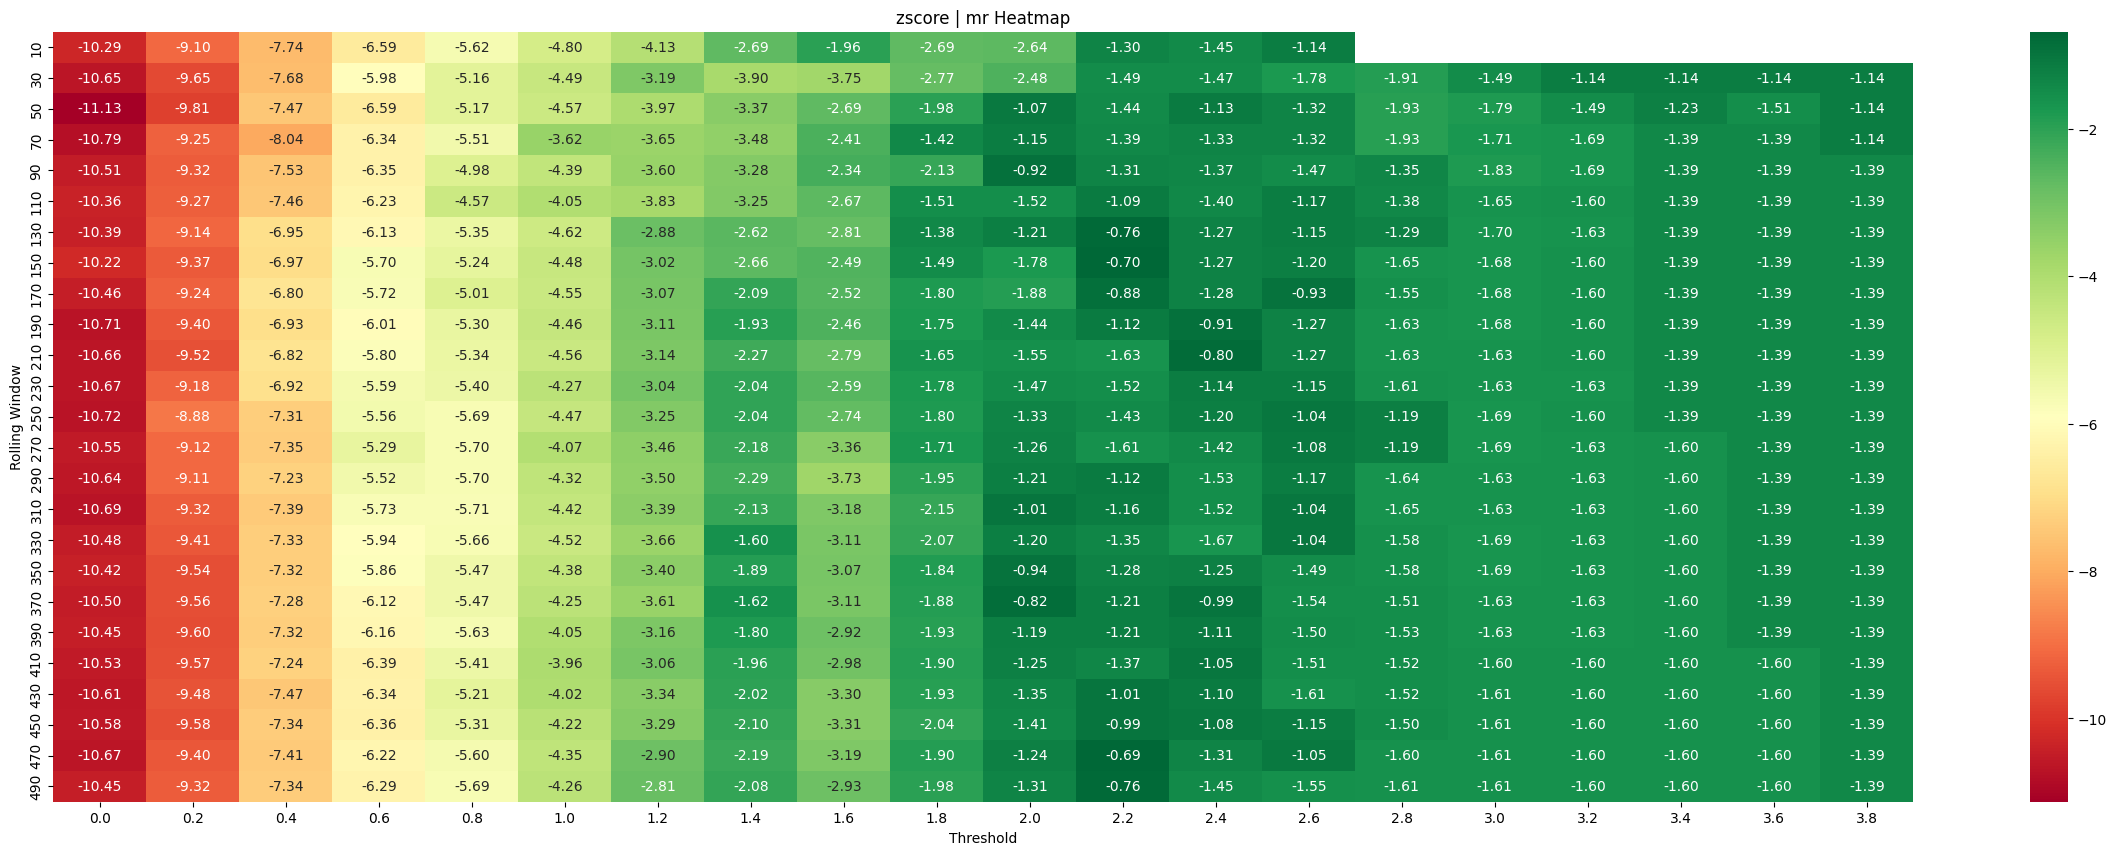

C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:127: RuntimeWarning: invalid value encountered in scalar divide
  sr = df["pnl"].mean() / df["pnl"].std() * np.sqrt(365 * sr_multiplier)
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:128: RuntimeWarning: invalid value encountered in scalar divide
  cr = df["pnl"].mean() / abs(df["dd"].min())
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:127: RuntimeWarning: invalid value encountered in scalar divide
  sr = df["pnl"].mean() / df["pnl"].std() * np.sqrt(365 * sr_multiplier)
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:128: RuntimeWarning: invalid value encountered in scalar divide
  cr = df["pnl"].mean() / abs(df["dd"].min())
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\2717875404.py:127: RuntimeWarning: invalid value encountered in scalar divide
  sr = df["pnl"].mean() / df["pnl"].std() * np.sqrt(365 * sr_multiplier)
C:\Users\cheeh\AppData\Local\Temp\ipykernel_9596\27178

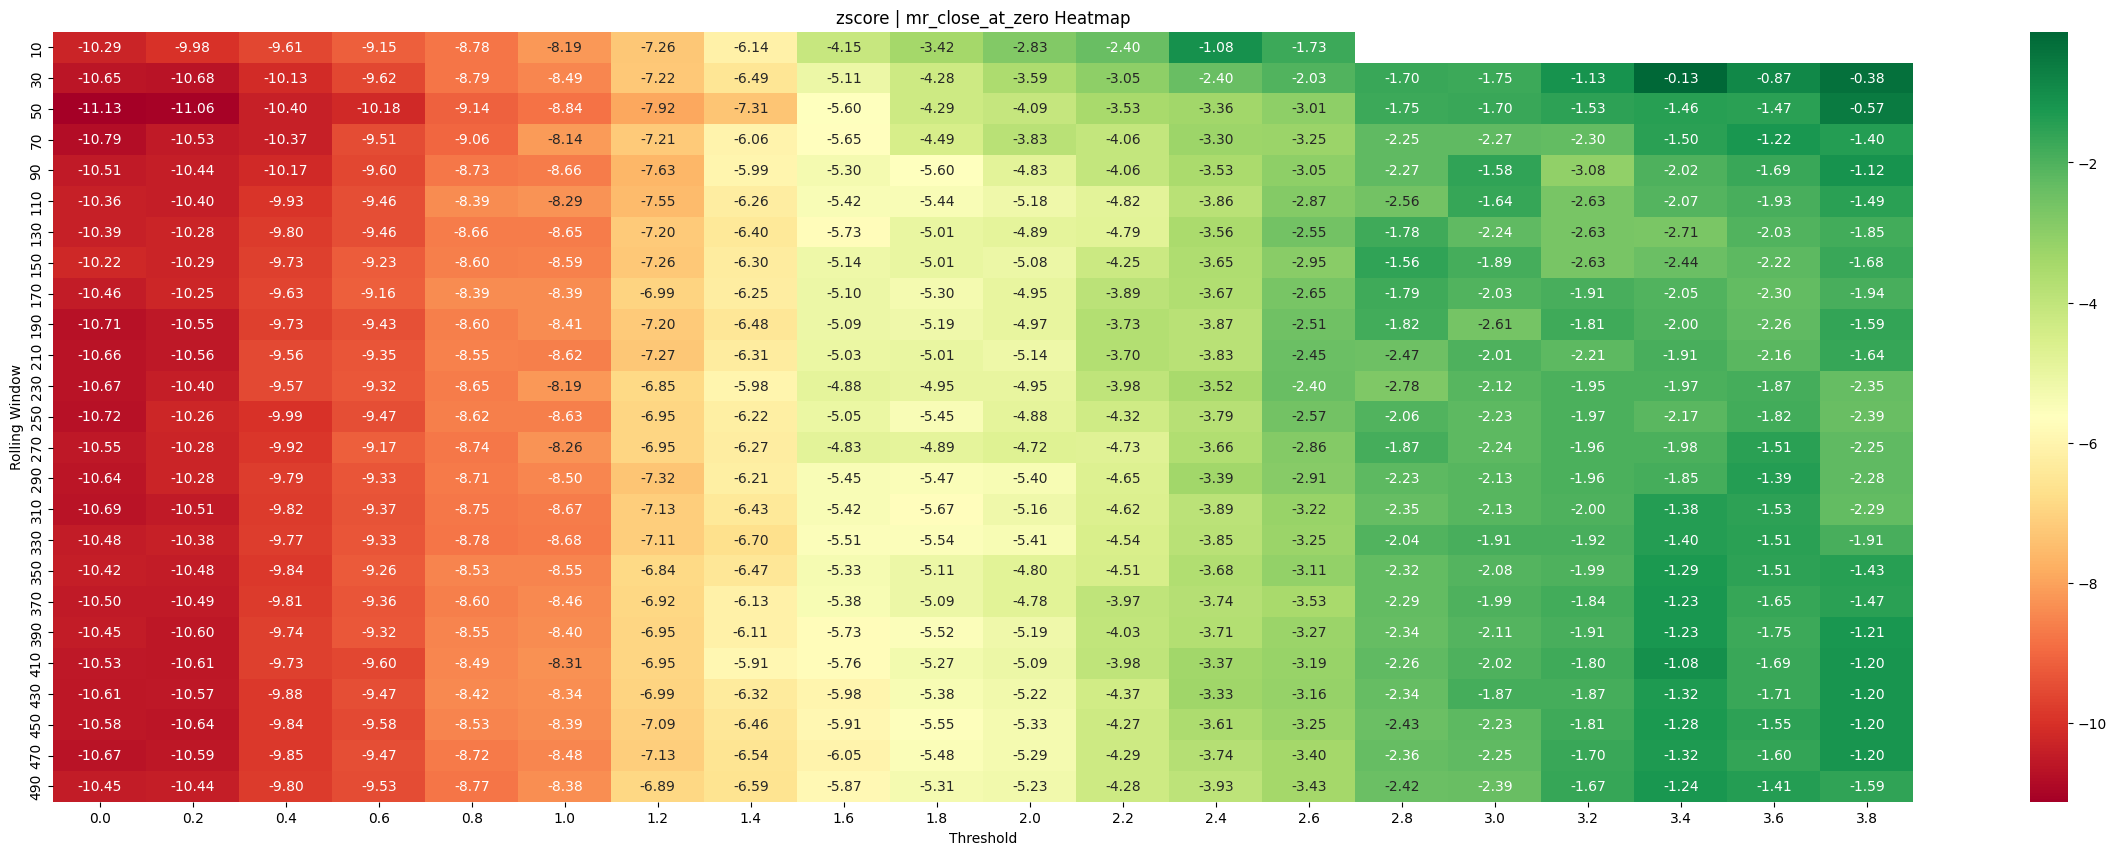

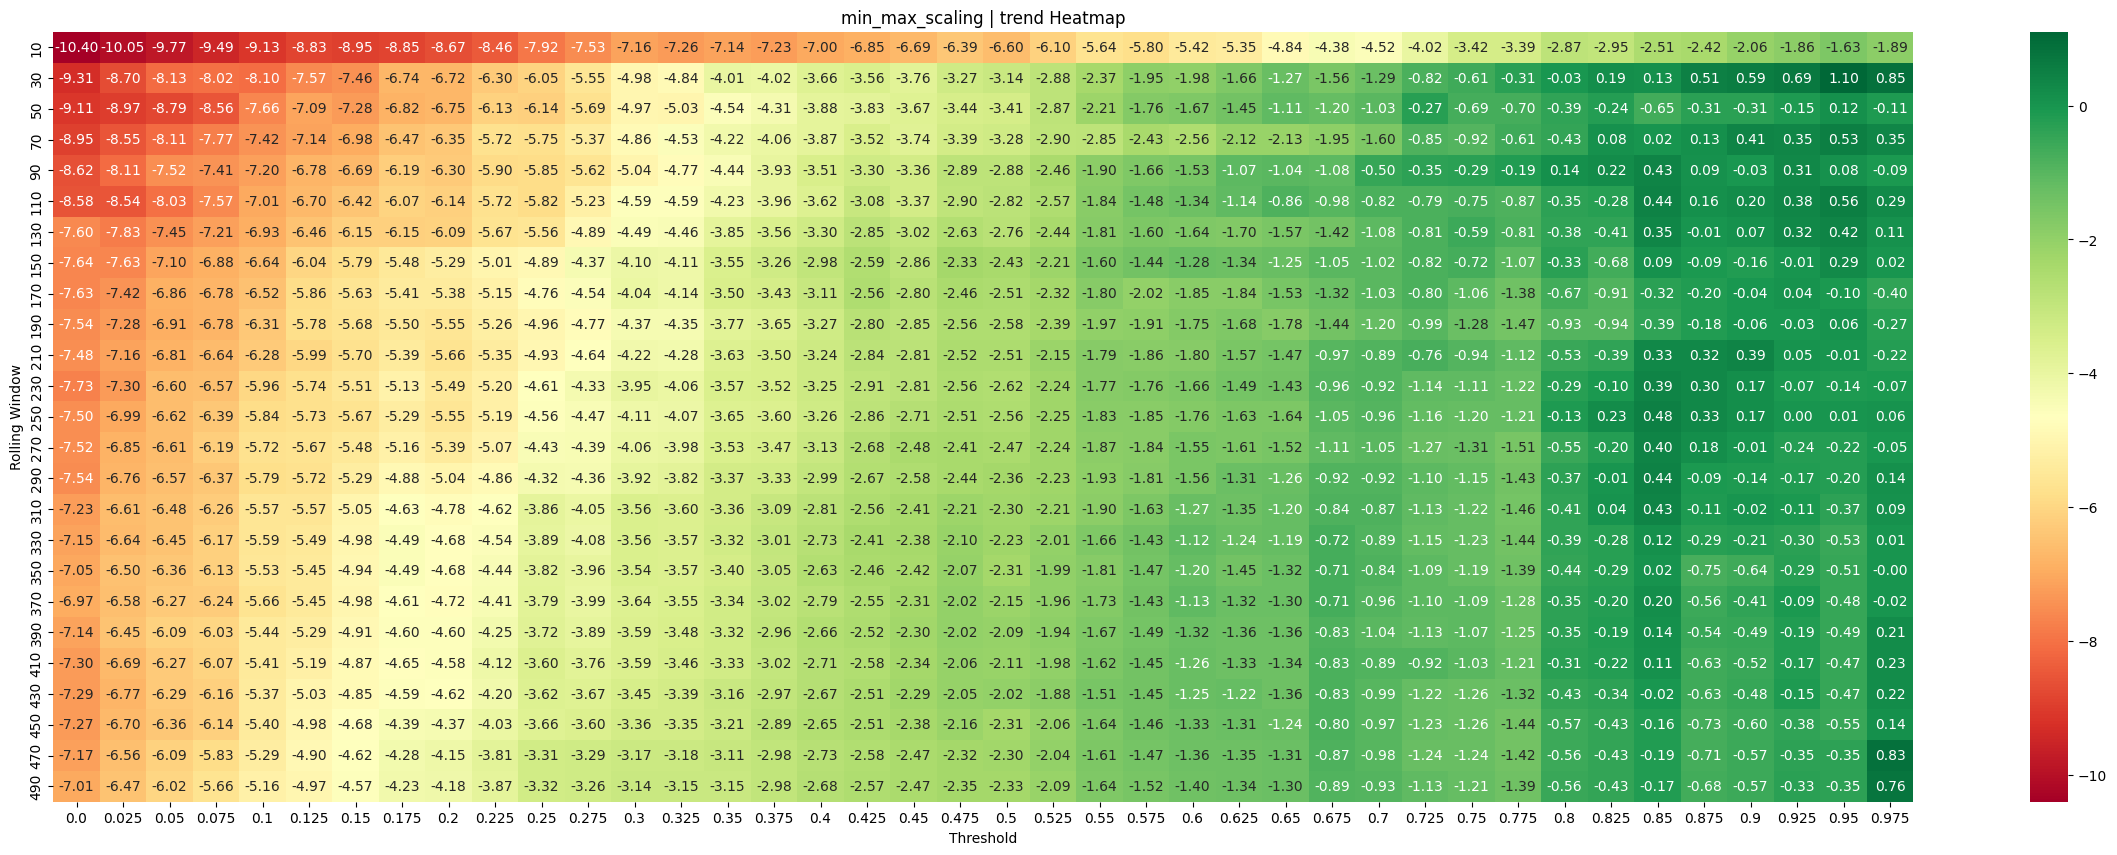

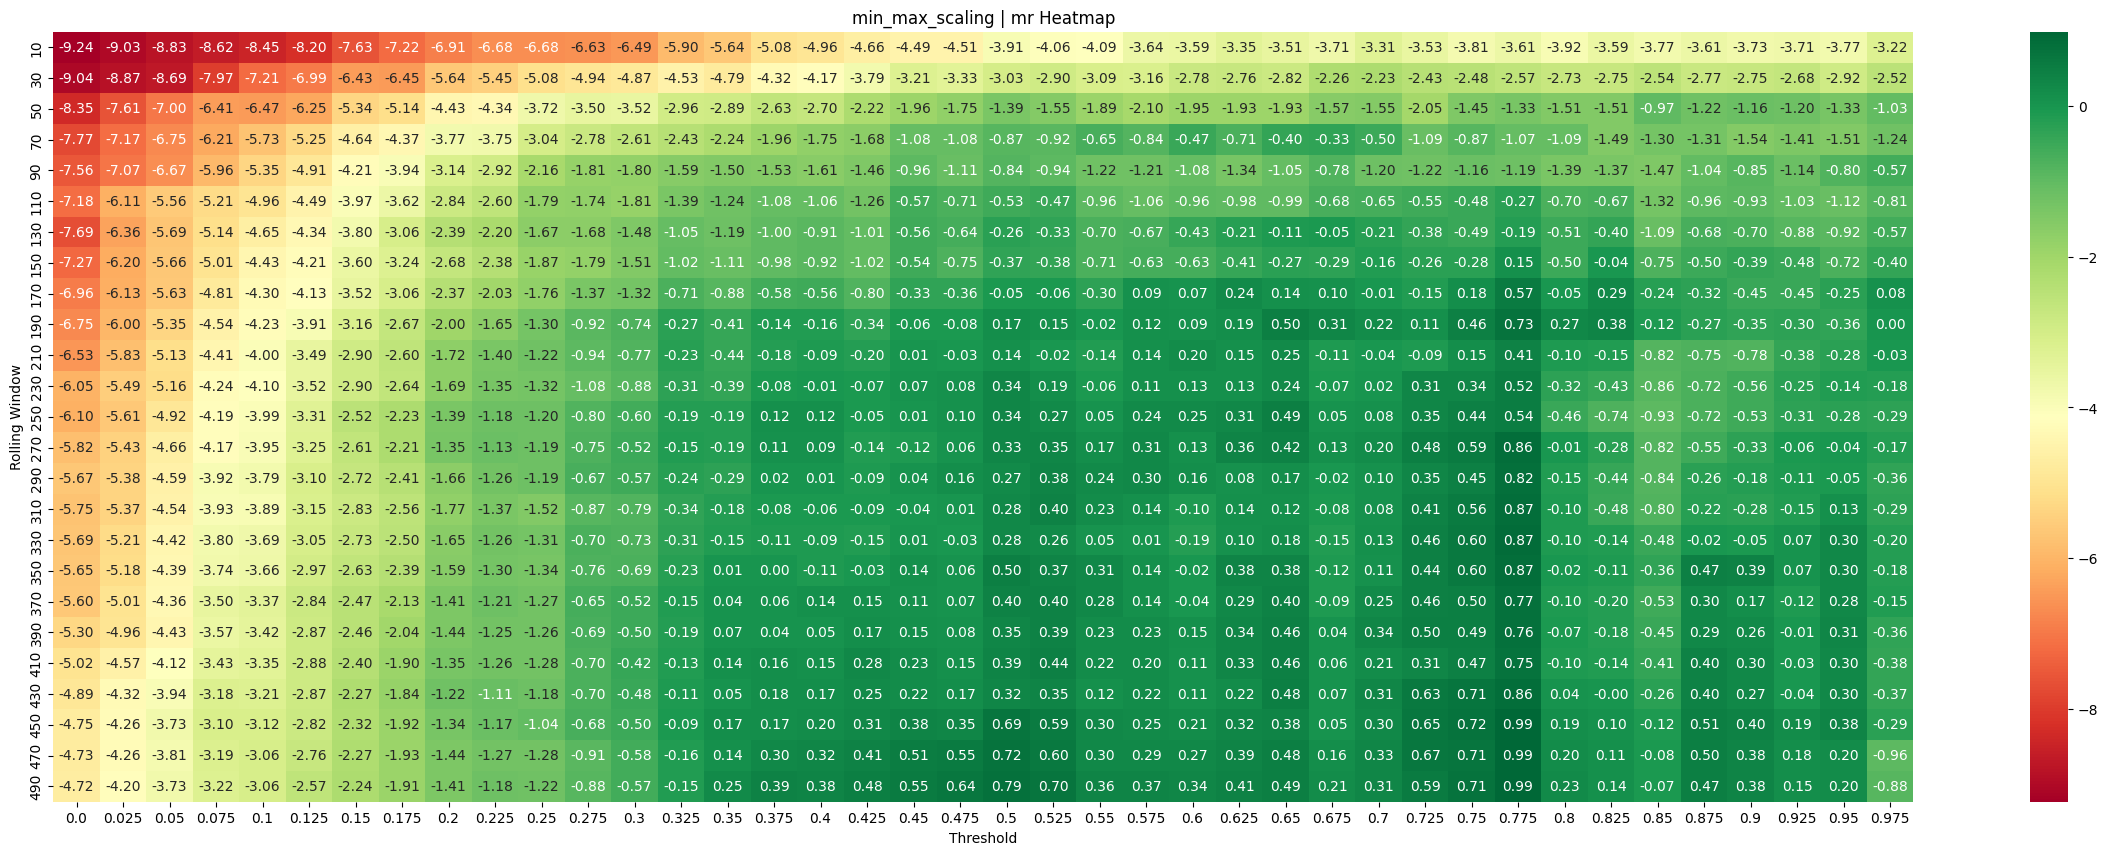

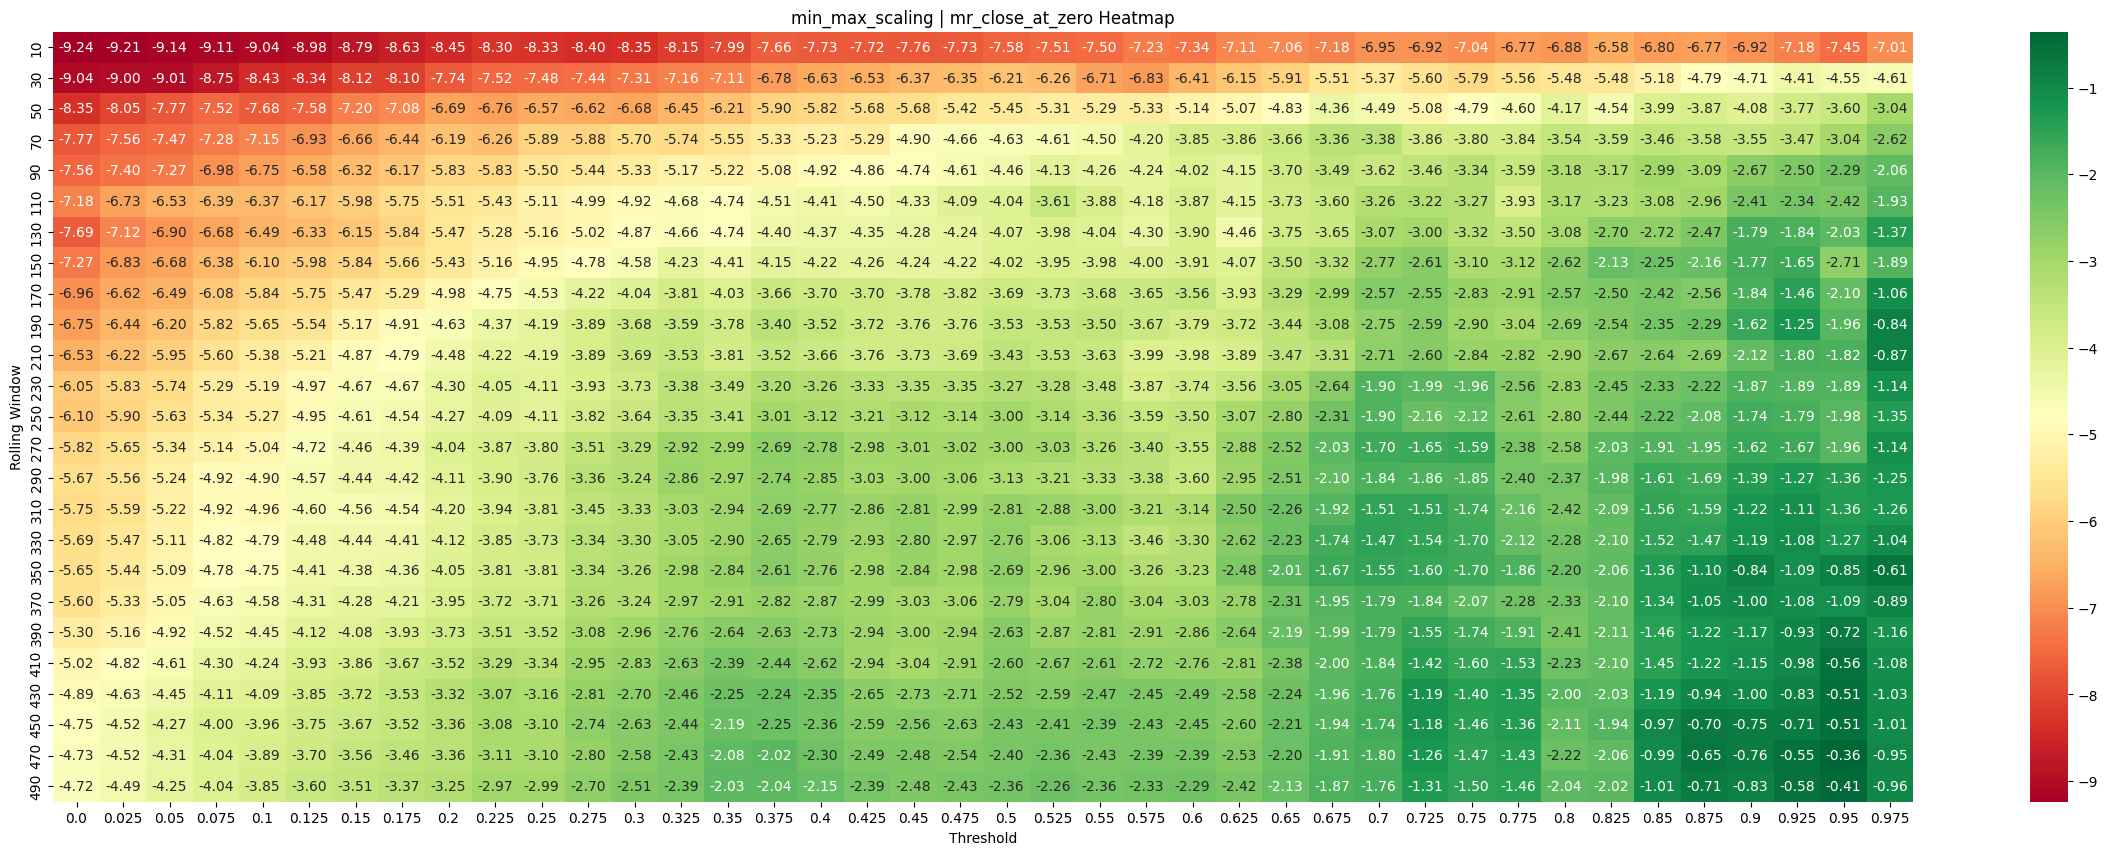

In [10]:
# rolling window from 10 to 500
# threshold from 0 to 4
# np.arrange(start, end, step size)
rolling_window_list = np.arange(10, 500, 20)

# model zscore , min_max
model_list = ["zscore", "min_max_scaling"]
# entry eixt, trend, mr , mr_close_at_zero
entry_exit_logic_list = ["trend", "mr", "mr_close_at_zero"]

for model in model_list:
    for entry_exit_logic in entry_exit_logic_list:
        # assign an array to store all report
        all_report = []
        if model == "zscore":
            threshold_list = np.arange(0, 4, 0.2)
        else:
            threshold_list = np.arange(0, 1, 0.025)
        # double loop to run all permutation backtesting
        for rolling_window in rolling_window_list:
            for threshold in threshold_list:
                # pass in window and threshold to backtest
                report, final_df = backtesting(
                    df=df.copy(),
                    rolling_window=rolling_window,
                    threshold=round(threshold, 3),
                    fees=0.06,
                    sr_multiplier=sr_multiplier,
                    entry_exit_logic=entry_exit_logic,
                    model=model,
                    column_name='factor',
                )
                # save the result
                all_report.append(report)

        # convert all results to dataframe
        report_df = pd.DataFrame(all_report)
        # get the pivot_table of allrepots
        pivot_table = report_df.pivot(
            index="Rolling Window", columns="Threshold", values="SR"
        )
        # adjust the figure size
        plt.figure(figsize=(30, 10))
        # Create heatmap
        sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="RdYlGn")
        # Show plot
        plt.title(f"{model} | {entry_exit_logic} Heatmap")
        plt.show()

In [ ]:
report1, final_df1 = backtesting(
    df=df.copy(),
    rolling_window=310,
    threshold=0.8,
    fees=0.06,
    sr_multiplier=sr_multiplier,
    entry_exit_logic="trend",
    model="zscore",
    column_name="coinbase_premium_gap",
)
report2, final_df2 = backtesting(
    df=df.copy(),
    rolling_window=310,
    threshold=0.925,
    fees=0.06,
    sr_multiplier=sr_multiplier,
    entry_exit_logic="trend",
    model="min_max_scaling",
    column_name="coinbase_premium_gap",
)

In [ ]:
final_df1 = final_df1.set_index("start_time")
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y=final_df1["cumu"],
        x=final_df1.index,
        mode="lines",
        name="Cumulative PnL",
        line=dict(width=2),
    )
)

fig.update_layout(
    title="Cumulative PnL Over Time",
    xaxis_title="Time (Index)",
    yaxis_title="Cumulative PnL",
    template="plotly_white",
)

fig.show()

In [ ]:
final_df2 = final_df2.set_index("start_time")
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y=final_df2["cumu"],
        x=final_df2.index,
        mode="lines",
        name="Cumulative PnL",
        line=dict(width=2),
    )
)

fig.update_layout(
    title="Cumulative PnL Over Time",
    xaxis_title="Time (Index)",
    yaxis_title="Cumulative PnL",
    template="plotly_white",
)

fig.show()

In [ ]:
final_df1["pnl"].corr(final_df2["pnl"])

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(final_df["pnl"], kde=True, bins=50, color="blue")
plt.axvline(0, color="red", linestyle="--", label="Break-even")
plt.title("PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
final_df1.reset_index(inplace=True)
final_df2.reset_index(inplace=True)
report_df1 = final_df1[["start_time", "pnl"]]
report_df2 = final_df2[["start_time", "pnl"]]
merge_df = pd.merge(report_df1, report_df2, how="left", on="start_time")
merge_df = merge_df.set_index("start_time")
merge_df["pnl_mean"] = (merge_df["pnl_x"] + merge_df["pnl_y"]) / 2
merge_df

In [ ]:
merge_df["cumu"] = merge_df["pnl_mean"].cumsum()
merge_df["dd"] = merge_df["cumu"] - merge_df["pnl_mean"].cummax()
sr = (
    merge_df["pnl_mean"].mean()
    / merge_df["pnl_mean"].std()
    * np.sqrt(365 * sr_multiplier)
)
cr = merge_df["pnl_mean"].mean() / abs(merge_df["dd"].min())
sortino_ratio = calculate_sortino_ratio(merge_df["pnl_mean"])
ar = merge_df["pnl_mean"].mean() * 365
report = {
    "SR": sr,
    "CR": cr,
    "AR": ar,
    "MDD": merge_df["dd"].min(),
    "Sortino Ratio": sortino_ratio,
}
report

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y=merge_df["cumu"],
        x=merge_df.index,
        mode="lines",
        name="Cumulative PnL",
        line=dict(width=2),
    )
)

fig.update_layout(
    title="Cumulative PnL Over Time",
    xaxis_title="Time (Index)",
    yaxis_title="Cumulative PnL",
    template="plotly_white",
)

fig.show()